In [1]:
#plots.py
import os
import pandas
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import datetime
import math

def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "A"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            # setting i to None will cause the next block of code to execute,
            # placing data within df instead of creating a new dataframe for
            # each variable
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()

    return df

def plot_ts_scatter(df, s = 75, figsize = (40, 20), save_fig = False, pp = None):
    # Create plot for every unique pair of variables
    plot_vars = list(df.keys())
    for var1 in plot_vars:
        for var2 in plot_vars:
            if var1 != var2:
                fig, ax = plt.subplots(figsize = figsize)
                # Create list of years from index
                # Year will be represented by color
                if "Year" not in df.keys():
                    df["Year"] = [int(str(ind)[:4]) for ind in df.index] 
                df.plot.scatter(x = var1, y = var2, s = s, ax = ax, 
                                c = "Year", cmap = "viridis")
                # Turn the text on the x-axis so that it reads vertically
                ax.tick_params(axis='x', rotation=90)
                # Get rid of tick lines perpendicular to the axis for aesthetic
                ax.tick_params('both', length=0, which='both')
                # save image if PdfPages object was passed
                if save_fig:
                    try:
                        os.mkdir("plots")
                    except:
                        pass
                    plt.savefig("plots/" + str(plot_vars).replace("[", "").replace("]","")[:40] + " scatter.png",
                            bbox_inches = "tight")
                    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_lines(df, title = False, linewidth = 1, figsize = (40,20), full_index = False, 
               h_line = False, max_y = False, legend = True, pp = None, show_inversion = False):
    fig, ax = plt.subplots(figsize = figsize)
    # If no secondary_y (axis), plot all variables at once
    df.plot.line(linewidth = linewidth, ax = ax, legend = legend)
    if h_line != False:
        ax.axhline(h_line, ls = "--", linewidth = 1.5, color = "k")
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    if max_y != False:
        ax.set_ylim(bottom = 0, top = max_y)
    else:
        ax.set_ylim(bottom = 0)
    
    if full_index:
        plt.xticks([i for i in range(len(df.index))], list(df.index))
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals]) 

    # transform y-axis values from sci notation to integers
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals]) 
    if title != False:
        plt.title(title, fontsize = 72)

    if show_inversion:
        trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
        ax.fill_between(df.index, 0, df.max().max(), where=df["2 Y (%)"] < df["1 M (%)"],
                    facecolor='red', alpha=0.2, transform = trans)
    # format image filename 
    remove_chars = "[]:$'\\"
    filename = str(list(df.keys()))
    for char in remove_chars:
        filename = filename.replace(char, "")
    plt.savefig(filename[:50] + " line.png",
                bbox_inches = "tight")
    #[:50] + " line.png"
    # save image if PdfPages object was passed
    if pp != None: pp.savefig(fig, bbox_inches = "tight")
    plt.close()

def plot_stacked_lines(df, plot_vars, linewidth = 1, figsize = (40,20), 
                       pp = None, total_var = False):
    fig, ax = plt.subplots(figsize = figsize)
#    mpl_colors = ["C" + str(i) for i in range(11)]
    df[plot_vars].plot.area(stacked = True, linewidth = linewidth,
                            ax = ax)
    if total_var != False:
        df[total_var].plot.line(linewidth = linewidth, ax = ax, c = "k",
              label = total_var, ls = "--")
    ax.legend(loc=2, ncol = 2)

In [2]:
data_codes  = {"1 M (%)": "DGS1MO",
               #"2 Month (%)": "DGS2MO",
               "3 M (%)": "DGS3MO",
               "6 M (%)": "DGS6MO",               
               "1 Y (%)": "DGS1",
               "2 Y (%)": "DGS2",
               "3 Y (%)": "DGS3",
               "5 Y (%)": "DGS5",
               "7 Y (%)": "DGS7",
               "10 Y (%)": "DGS10",
               "20 Y (%)": "DGS20",
               "30 Y (%)": "DGS30",
               "Federal Funds Target (Pre-Crisis)": "DFEDTAR",
               "Federal Funds (Upper) Target":"DFEDTARU",
               "Effective Federal Funds Rate":"DFF",
               "Interest on Excess Reserves":"IOER"}

 #             "Expected Inflation (%)":"T10YIE"}
               
# Select start and end dates
start = datetime.datetime(2006, 1, 1)
end = datetime.datetime.today()

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
data = gather_data(data_codes = data_codes, start = start, end = end, freq = "D")
data["30 Y - 1 M"] = data["30 Y (%)"].sub(data["1 M (%)"])
#data["Inflation (%)"] = data["Inflation (%)"].pct_change(12)*100

In [3]:
data

,1 M (%),3 M (%),6 M (%),1 Y (%),2 Y (%),3 Y (%),5 Y (%),7 Y (%),10 Y (%),20 Y (%),30 Y (%),Federal Funds Target (Pre-Crisis),Federal Funds (Upper) Target,Effective Federal Funds Rate,Interest on Excess Reserves,30 Y - 1 M
DATE,,,,,,,,,,,,,,,,
2006-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.25,NaN,4.09,NaN,NaN
2006-01-03,4.05,4.16,4.40,4.38,4.34,4.30,4.30,4.32,4.37,4.62,4.52,4.25,NaN,4.34,NaN,0.47
2006-01-04,4.03,4.19,4.37,4.35,4.31,4.28,4.28,4.31,4.36,4.60,4.55,4.25,NaN,4.22,NaN,0.52
2006-01-05,4.05,4.20,4.37,4.36,4.32,4.29,4.29,4.31,4.36,4.61,4.51,4.25,NaN,4.24,NaN,0.46
2006-01-06,4.06,4.22,4.39,4.38,4.36,4.32,4.32,4.33,4.38,4.63,4.53,4.25,NaN,4.22,NaN,0.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-04,0.18,0.66,1.14,1.72,2.43,2.61,2.56,2.52,2.42,2.64,2.48,NaN,0.5,0.33,NaN,2.30
2022-04-05,0.18,0.65,1.13,1.77,2.51,2.69,2.69,2.65,2.54,2.74,2.57,NaN,0.5,0.33,NaN,2.39
2022-04-06,0.21,0.67,1.15,1.79,2.50,2.67,2.70,2.69,2.61,2.81,2.63,NaN,0.5,0.33,NaN,2.42


In [4]:
plt.rcParams.update({'font.size': 32})
plt.rcParams['axes.ymargin'] = 0
plot_vars = ["Federal Funds Target (Pre-Crisis)",
             "Federal Funds (Upper) Target",
             "Interest on Excess Reserves",
             "Effective Federal Funds Rate",
             "1 M (%)"]

plot_lines(df = data[plot_vars], linewidth = 1.5, figsize = (40, 20), pp = None, show_inversion = False)

<ipython-input-1-f16760372b65>:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])
<ipython-input-1-f16760372b65>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


In [5]:

plot_lines(df = data, linewidth = 1.5, figsize = (40, 20), pp = None, show_inversion = True)

<ipython-input-1-f16760372b65>:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])
<ipython-input-1-f16760372b65>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


<ipython-input-1-f16760372b65>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Year"] = [int(str(ind)[:4]) for ind in df.index]


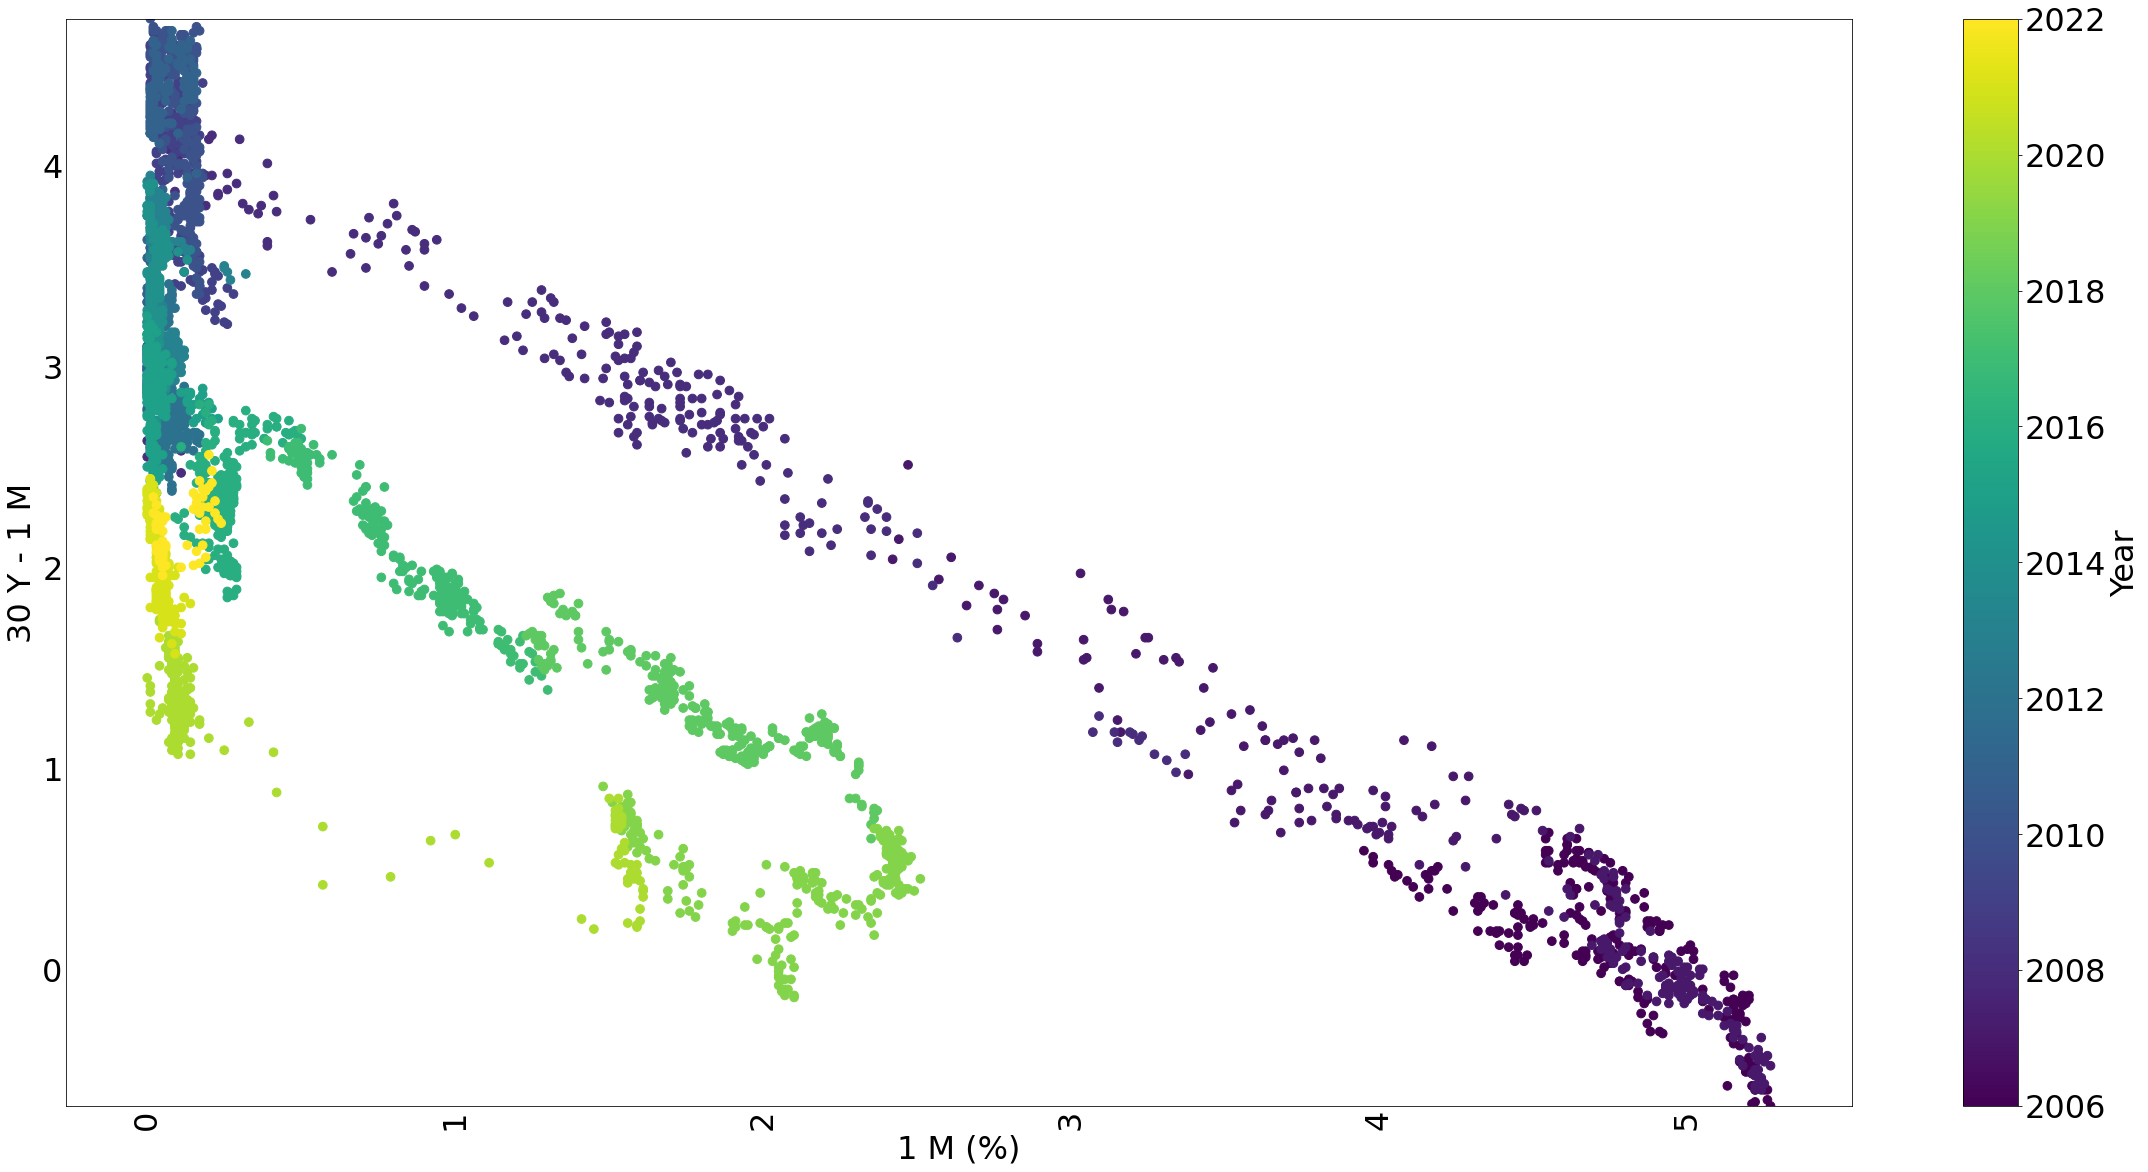

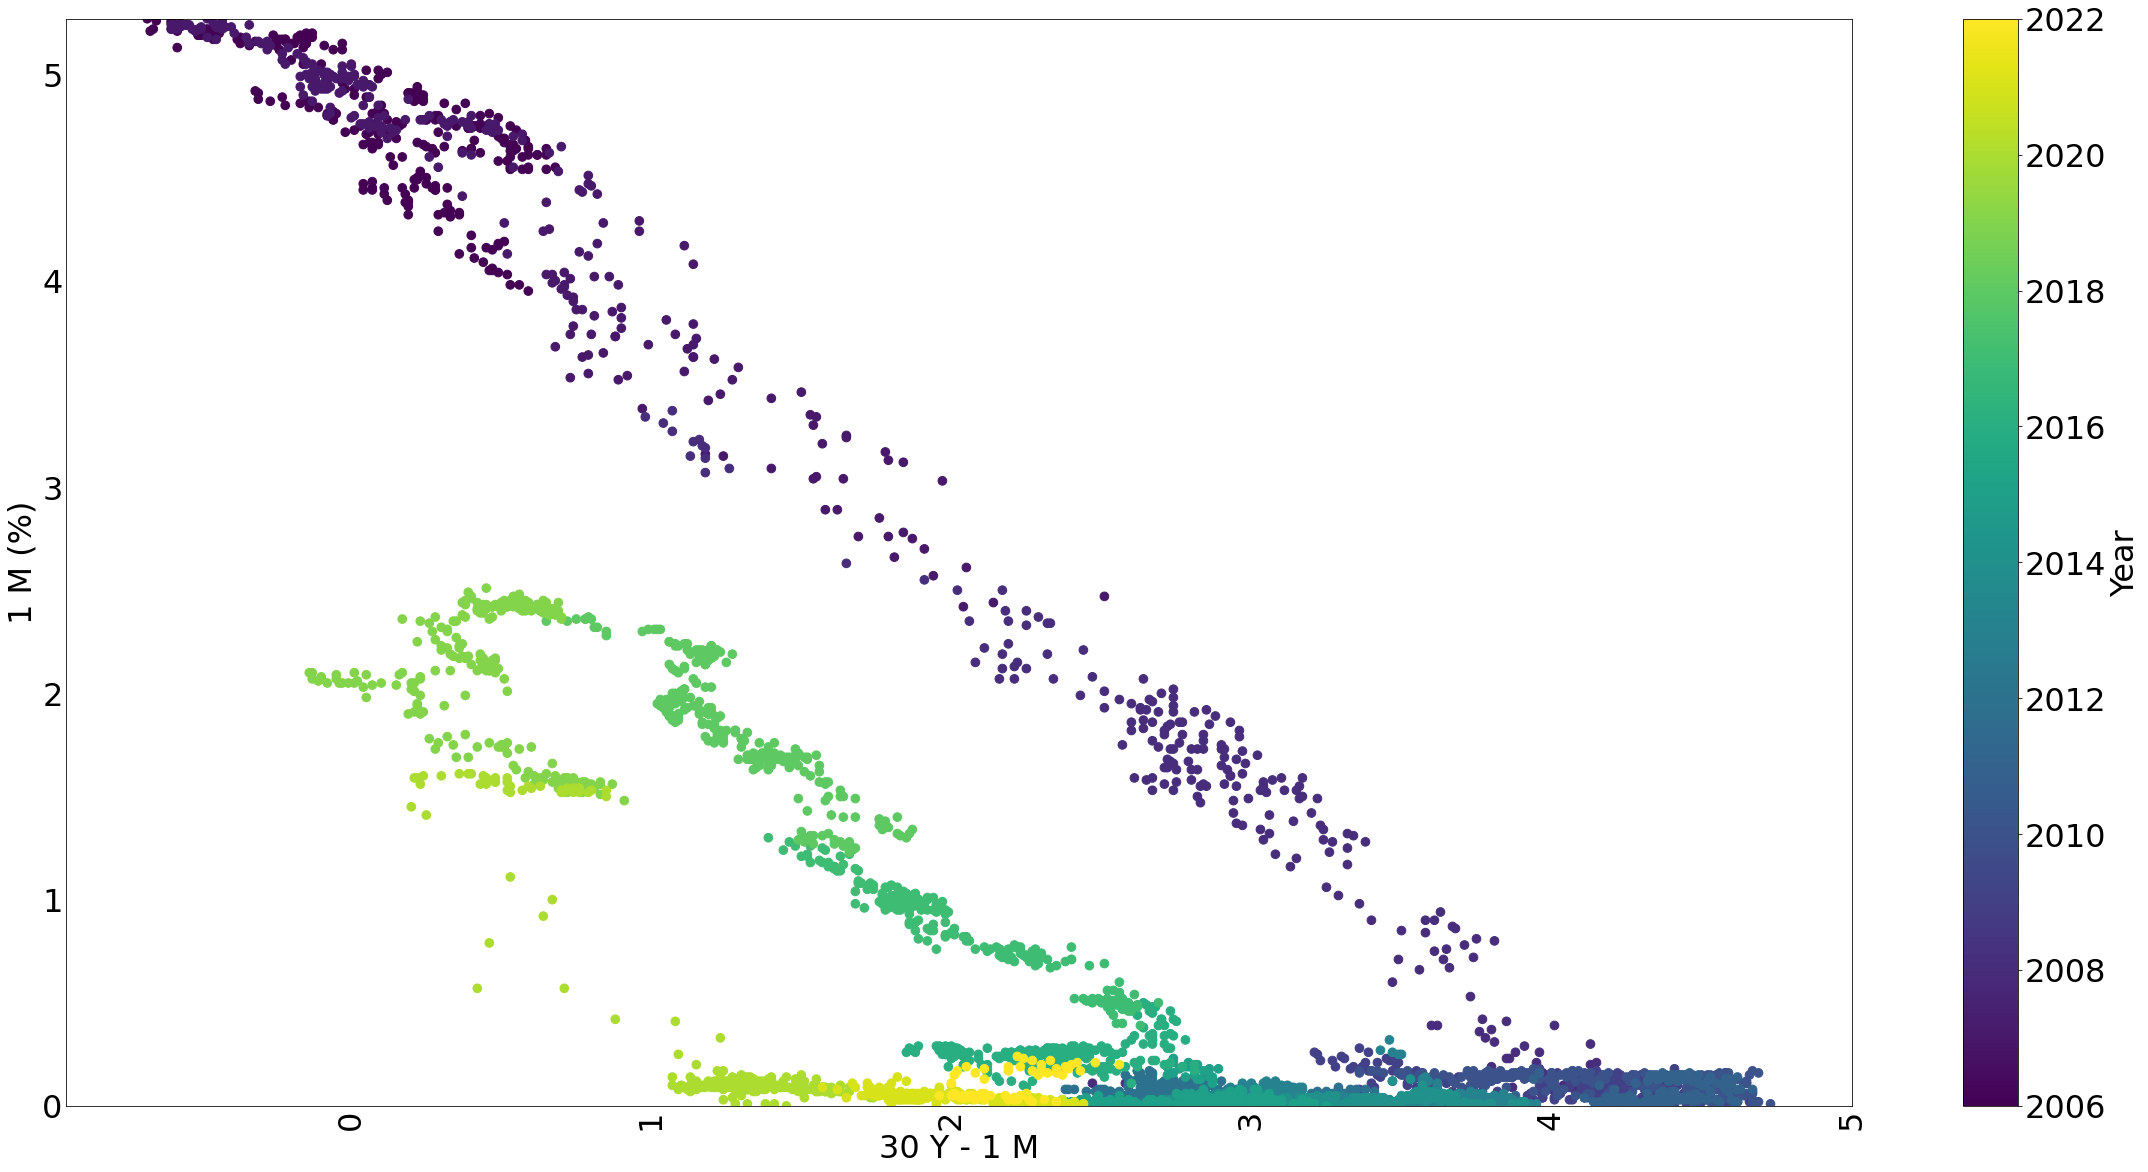

In [6]:
plot_ts_scatter(data[["1 M (%)", "30 Y - 1 M"]], s = 75, figsize = (40, 20))

In [7]:
plot_lines(df = data[["1 M (%)", "30 Y (%)", "30 Y - 1 M"]], title = "Yields", linewidth = 1.5, figsize = (40, 20), pp = None)

<ipython-input-1-f16760372b65>:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])
<ipython-input-1-f16760372b65>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


In [8]:
T_data = data.T
T_data.rename(columns={name : str(name)[:10] for name in T_data.keys()}, inplace = True)
keys = list(T_data.keys())
# Plot all maturities, remove "30 Y - 1 M" dataframe
T_data_trunc = T_data[keys[::250]].drop("30 Y - 1 M")
max_y = T_data.max().max()
#for key, val in T_data_trunc.items():
plot_lines(df = T_data_trunc, title = "Yield Curve", linewidth = 1.5, 
           figsize = (40, 20), full_index = True, legend = True, pp = None)

<ipython-input-1-f16760372b65>:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])
<ipython-input-1-f16760372b65>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


In [9]:
# Plot all maturities, remove "30 Y - 1 M" dataframe
T_data_trunc = T_data[keys[::250]].drop("30 Y - 1 M")
from matplotlib.backends.backend_pdf import PdfPages
pp = PdfPages("yieldCurveYearly.pdf")
for key in keys[::250]:
    max_y = T_data.max().max()
    #for key, val in T_data_trunc.items():
    plot_lines(df = T_data_trunc[key], title = "Yield Curve", linewidth = 1.5, 
               figsize = (40, 20), full_index = True, legend = True, max_y = max_y,
               pp = pp)
pp.close()

<ipython-input-1-f16760372b65>:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])
<ipython-input-1-f16760372b65>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])
<ipython-input-1-f16760372b65>:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])
<ipython-input-1-f16760372b65>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])
<ipython-input-1-f16760372b65>:75: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])
<ipython-input-1-f16760372b65>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])
<ipython-input-1-f16760372b65>:75: UserWarning

In [10]:
from matplotlib.animation import FuncAnimation
import math         
def plot_curves(date, *kwargs):
    #ax.clear()
    ax.set_ylim(bottom = 0, top = max_y)
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals])
 
    # the FuncAnimation cycles from 0 to i frames,
    plot_df = df[date]
    alpha = 1 if date in write_dates else .1
    color = "C" + str(math.ceil(int(date[5:7])/3)) if date != write_dates[0] else "k"

    # If no secondary_y (axis), plot all variables at once

    plot_df.plot.line(linewidth = linewidth, ax = ax, alpha = alpha, color = color)
    if date in write_dates: 
        plt.text(len(plot_df.keys()) - 1, plot_df["30 Y (%)"], date[5:], color = color)
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    ax.set_title(str(date)[:10] + "\n" + "Yield Curve (U.S. Treasuries)", fontsize = 30)
    print(date)
    
def init(*kwargs):
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    plt.xticks([i for i in range(len(data.index))], list(data.index))
    ax.tick_params(axis='x', rotation=90)
    # transform y-axis values from sci notation to integers
    ax.set_ylim(bottom = 0, top = max_y)
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals])

dates = list(T_data.keys())[-166:]
write_dates = dates[-1:0:-20]
df = T_data[dates].drop("30 Y - 1 M", axis = 0)
max_y = df.max().max()
fig, ax = plt.subplots(figsize=(40,20))   
plt.rcParams.update({"font.size": 30})
linewidth = 5
# the functions will unpack the tuple. The same names variable names
# are used in the function
kwargs = (df, fig, ax, max_y, linewidth, write_dates)
frames = dates
anim = FuncAnimation(fig, plot_curves, frames = frames, 
                     blit = False, init_func = init, interval=100, 
                     fargs =kwargs)
# Use the next line to save the video as an MP4.
anim.save("2020CrisisYieldCurve.mp4", writer = "ffmpeg")
plt.close()

<ipython-input-10-e7d6dbf24ca9>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-10-25


<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-10-26


<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-10-27


<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-10-28


<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-10-29


<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-10-30


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-10-31


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-01


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-02


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-03


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-04


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-05


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-06


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-07


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-08


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-09


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-10


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-11


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-12


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-13


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-14


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-15


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-16


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-17


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-18


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-19


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-20


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-21


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-22


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-23


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-24


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-25


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-26


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-27


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-28


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-29


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-11-30


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-01


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-02


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-03


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-04


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-05


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-06


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-07


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-08


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-09


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-10


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-11


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-12


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-13


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-14


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-15


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-16


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-17


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-18


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-19


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-20


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-21


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-22


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-23


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-24


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-25


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-26


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-27


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-28


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-29


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-30


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2021-12-31


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-01


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-02


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-03


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-04


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-05


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-06


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-07


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-08


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-09


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-10


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-11


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-12


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-13


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-14


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-15


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-16


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-17


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-18


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-19


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-20


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-21


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-22


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-23


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-24


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-25


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-26


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-27


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-28


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-29


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-30


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-01-31


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-01


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-02


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-03


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-04


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-05


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-06


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-07


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-08


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-09


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-10


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-11


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-12


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-13


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-14


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-15


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-16


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-17


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-18


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-19


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-20


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-21


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-22


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-23


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-24


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-25


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-26


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-27


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-02-28


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-01


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-02


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-03


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-04


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-05


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-06


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-07


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-08


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-09


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-10


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-11


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-12


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-13


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-14


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-15


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-16


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-17


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-18


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-19


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-20


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-21


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-22


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-23


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-24


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-25


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-26


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-27


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-28


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-29


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-30


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-03-31


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-04-01


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-04-02


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-04-03


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-04-04


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-04-05


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-04-06


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-04-07


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2022-04-08


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


In [ ]:
dates = list(T_data.keys())[620:770]
write_dates = dates[-1:0:-20]
df = T_data[dates].drop("30 Y - 1 M", axis = 0)
max_y = df.max().max()
fig, ax = plt.subplots(figsize=(40,20))   
plt.rcParams.update({"font.size": 30})
linewidth = 5
# the functions will unpack the tuple. The same names variable names
# are used in the function
kwargs = (df, fig, ax, max_y, linewidth, write_dates)
frames = dates
anim = FuncAnimation(fig, plot_curves, frames = frames, 
                     blit = False, init_func = init, interval=100, 
                     fargs =kwargs)
# Use the next line to save the video as an MP4.
anim.save("2008CrisisYieldCurve.mp4", writer = "ffmpeg")
plt.close()

<ipython-input-10-e7d6dbf24ca9>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-09-14


<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-09-15


<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-09-16


<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-09-17


<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-09-18


<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-09-19


<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-09-20


<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-09-21


<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-09-22


<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-09-23


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-09-24


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-09-25


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-09-26


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-09-27


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-09-28


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-09-29


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-09-30


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-01


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-02


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-03


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-04


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-05


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-06


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-07


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-08


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-09


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-10


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-11


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-12


posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-13


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-14


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-15


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-16


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-17


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-18


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-19


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-20


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-21


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-22


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-23


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-24


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-25


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-26


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-27


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-28


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-29


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-30


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-10-31


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-11-01


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-11-02


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-11-03


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-11-04


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-11-05


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-11-06


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-11-07


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-11-08


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-11-09


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-11-10


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-11-11


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])


2007-11-12


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
<ipython-input-10-e7d6dbf24ca9>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([round(y,2) for y in vals])
